In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras import optimizers, regularizers
from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential
from random import shuffle
from scipy import interp
from sklearn.linear_model import LogisticRegression
from scipy.stats.mstats import gmean
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import QuantileTransformer
import contextlib
import glob
import gzip
import h5py
import keras
import numpy as np
import os
import pandas as pd
import pylab as plt
import random
import scipy
import sklearn
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC


random_state = np.random.RandomState(0)


In [ ]:
X_f_ext = '/content/drive/MyDrive/coursework/mutagenicity-fingerprints.csv'

X = pd.read_csv(X_f_ext,sep=',')
X['Mutagenicity_bin'] = np.int32(X['Mutagenicity'] == 'mutagenic')
del X['Mutagenicity']



In [ ]:
X

,Canonical SMILES,10;1-1-1;1-1-10;2-1-1;,10;1-1-1;1-1-10;2-1-1;2-1-2;,10;1-1-1;1-1-10;2-1-1;2-1-3;,10;1-1-1;1-1-10;2-2-1;,10;1-1-1;1-1-10;2-2-1;2-1-2;2-1-28;,10;1-1-1;1-1-10;2-3-1;,10;1-1-1;1-1-10;2-3-1;2-1-2;,10;1-1-1;1-1-12;2-1-1;2-1-2;2-1-8;2-1-9;2-1-10;,10;1-1-1;1-1-12;2-1-1;2-1-2;2-2-8;2-1-18;,...,9;1-2-3;2-2-3;,9;1-2-3;2-2-3;2-1-11;,9;1-2-3;2-2-3;2-1-8;2-1-11;,9;1-2-3;2-2-3;2-1-9;2-1-11;,9;1-2-3;2-3-3;,9;1-2-3;2-3-3;2-1-11;,9;1-2-3;2-3-3;2-1-19;,9;1-2-3;2-3-3;2-1-9;,9;1-2-3;2-4-3;,Mutagenicity_bin
0,O=C1c2ccccc2C(=O)c2c1c1[nH]c3c(c1c1c2[nH]c2c1c...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NNC(=O)CNC(=O)C=N#N,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,N1C(=O)C(=N#N)C=NC1=O,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,NC(=O)CNC(=O)C=N#N,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,CCCCN(CC(C1=CC(=N#N)C(=O)C=C1)O)N=O,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8304,Nc1ccc2c(c1)[n+](C)c1c(c2)ccc(c1)N.Nc1ccc2c(c1...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8305,N/N=C/1\N=NC=C2[C@H]1C=CC=C2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8306,O[C@H]([C@H](C(=O)O)O)C(=O)O.[K+],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8307,O[C@H]([C@H](C(=O)O)O)C(=O)O.CCCn1cc2c3c1cccc3...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
X_f_ext = '/home/drewe/notebooks/genotox/mutagenicity-mod-2.csv'

X_ext = pd.read_csv(X_f_ext,sep=';')

In [ ]:
X = pd.merge(X[['Canonical SMILES','Mutagenicity_bin']], X_ext, left_on='Canonical SMILES', right_on='Name')
y = X['Mutagenicity_bin'].values


NameError: ignored

In [ ]:
y = X['Mutagenicity_bin'].values

In [ ]:
#X.to_csv('/home/drewe/notebooks/genotox/mutagenicity-mod-2.new.csv')
#X.set_index('Canonical SMILES').to_csv('/home/drewe/notebooks/genotox/mutagenicity-mod-2.new.csv')

In [ ]:
del X['Mutagenicity_bin']


In [ ]:
names = X['Canonical SMILES'].values
del X['Canonical SMILES']

X = np.float64(X.values[:,1:])

ix = [i for i in range(y.shape[0])]
shuffle(ix)
X  = X[ix, :]
names = names[ix]
y = y[ix]


In [ ]:
X.shape

(8309, 9637)

In [ ]:
cv = StratifiedKFold(n_splits=10)
results = np.zeros_like(y, dtype=float)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    keras.backend.clear_session()
    prbs=[]
    quant_trans = sklearn.preprocessing.QuantileTransformer(output_distribution='uniform').fit(X[train,:])
    for mod in range(5):
        print('>>')
        curr_try = 0
        while curr_try <10:
            print('.')

            model = Sequential()
            model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            # Compile model
            opt = keras.optimizers.Adam(epsilon=None, amsgrad=True)
            model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
            
            # Fit the model
            history = model.fit(quant_trans.transform(X[train,:]), y[train], epochs=50, batch_size=64, verbose=0)
            if history.history['acc'][-1] > 0.53:
                break
            else:
                curr_try += 1

        # Fit the model
        model.fit(quant_trans.transform(X[train,:]), y[train], epochs=50, batch_size=64, verbose=1)
        
        # evaluate the model
        probas_ = model.predict(quant_trans.transform(X[test,:]))
        prbs.append(probas_)
    # Average the predictions
    probas_ = np.mean(np.hstack(prbs), axis=1)
    results[test] = probas_
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[ :])
    print('   ' + str(auc(fpr, tpr)))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1

>>
.


AttributeError: ignored

In [ ]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
results

In [ ]:
#Logistic regression (SGD)
cv = StratifiedKFold(n_splits=10)
results = np.zeros_like(y, dtype=float)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    keras.backend.clear_session()
    prbs=[]
    
    quant_trans = sklearn.preprocessing.QuantileTransformer(output_distribution='uniform').fit(X[train,:])
    for mod in range(5):
        print('>>')
        curr_try = 0
        while curr_try <10:
            print('.')

            model = Sequential()
            model.add(Dense(1, activation='sigmoid'))
            # Compile model
            opt = keras.optimizers.Adam(epsilon=None, amsgrad=True)
            model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
            
            # Fit the model
            history = model.fit(quant_trans.transform(X[train,:]), y[train], epochs=50, batch_size=64, verbose=0)
            if history.history['acc'][-1] > 0.53:
                break
            else:
                curr_try += 1

        # Fit the model
        model.fit(quant_trans.transform(X[train,:]), y[train], epochs=50, batch_size=64, verbose=1)
        
        # evaluate the model
        probas_ = model.predict(quant_trans.transform(X[test,:]))
        prbs.append(probas_)
    # Average the predictions
    probas_ = np.mean(np.hstack(prbs), axis=1)
    results[test] = probas_
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[ :])
    print('   ' + str(auc(fpr, tpr)))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
results

In [ ]:
#Logistic regression (scikit)
cv = StratifiedKFold(n_splits=10)
results = np.zeros_like(y, dtype=float)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    keras.backend.clear_session()
    prbs=[]
    model = LogisticRegression(random_state=0)
    
    quant_trans = sklearn.preprocessing.QuantileTransformer(output_distribution='uniform').fit(X[train,:])
    #quantile_transform(X, axis=1, output_distribution='uniform', copy=True)
    model.fit(quant_trans.transform(X[train,:]), y[train])
    probas_ = model.predict_proba(quant_trans.transform(X[test,:]))[:, 1]
    results[test] = probas_
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[ :])
    print('   ' + str(auc(fpr, tpr)))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
results

>>
   0.9149390653840042
>>
   0.9166228654549011
>>
   0.8925973914850445
>>
   0.8909884077151189
>>
   0.900546528441536
>>
   0.9140075484645737
>>
   0.9102731416807588
>>
   0.9001053844080092
>>
   0.910092395167022
>>
   0.918032987770507


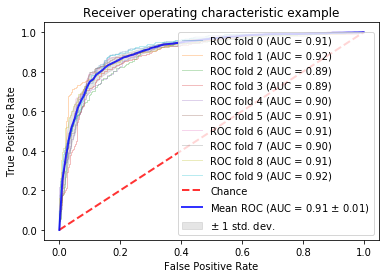

array([0.11857681, 0.17034412, 0.19707971, ..., 0.56568894, 0.24659538,
       0.23726879])

In [ ]:
cv = StratifiedKFold(n_splits=10)
results = np.zeros_like(y, dtype=float)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    print('>>')
    keras.backend.clear_session()
    prbs=[]
    model = RandomForestClassifier(n_estimators=1000, random_state=0, max_leaf_nodes=200)
    # Fit the model
    quant_trans = sklearn.preprocessing.QuantileTransformer(output_distribution='uniform').fit(X[train,:])
    #quantile_transform(X, axis=1, output_distribution='uniform', copy=True)
    model.fit(quant_trans.transform(X[train,:]), y[train])
    probas_ = model.predict_proba(quant_trans.transform(X[test,:]))[:, 1]
    results[test] = probas_

    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[ :])
    print('   ' + str(auc(fpr, tpr)))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
results

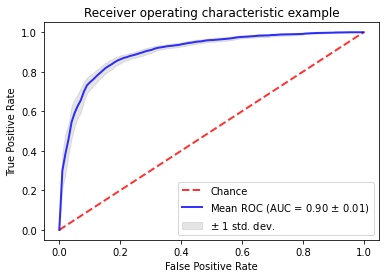

array([0.33262343, 0.00366417, 0.76689331, ..., 0.10576233, 0.95774969,
       0.02858322])

In [ ]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
results

In [ ]:
cv = StratifiedKFold(n_splits=10)
results = np.zeros_like(y, dtype=float)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    print('>>')
    keras.backend.clear_session()
    prbs=[]
    model = SVC(kernel='rbf', gamma='scale', probability=True)
    # Fit the model
    quant_trans = sklearn.preprocessing.QuantileTransformer(output_distribution='uniform').fit(X[train,:])
    #quantile_transform(X, axis=1, output_distribution='uniform', copy=True)
    model.fit(quant_trans.transform(X[train,:]), y[train])
    probas_ = model.predict_proba(quant_trans.transform(X[test,:]))[:, 1]
    predictions_ = model.predict(quant_trans.transform(X[test,:]))
    print(accuracy_score(y[test],predictions_)*100)
    results[test] = probas_

    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[ :])
    print('   ' + str(auc(fpr, tpr)))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
results

>>
84.71720818291215
   0.9155697815885522
>>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


83.03249097472924
   0.9056167081860842
>>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


86.5222623345367
   0.9256995539076531
>>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


83.51383874849579
   0.9021193756590459
>>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


84.11552346570397
   0.9134955213849524
>>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


85.67990373044525
   0.9227279574502602
>>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


83.51383874849579
   0.9016442832477781
>>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


83.03249097472924
   0.9088923394245588
>>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


83.75451263537906
   0.8973307917820601
>>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
